# Interpret Results of Trained GCN
In this notebook, I'll try to visualize the learning of a trained GCN model. This should involve the following steps:
* Interpret the predictions made by the model
* Visualize the filters of the Graph Convolution
* Do a TSNE plot of the last layer

In [1]:
# classics
import numpy as np
import pandas as pd
import random, h5py
import tensorflow as tf
import math

# my tool and sparse stuff for feature extraction
from gcn.utils import *
import sys, os
sys.path.append(os.path.abspath('../GCN'))
from my_gcn import MYGCN
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse import coo_matrix

# sklearn imports
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import svm

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn
import matplotlib.mlab as mlab

# set options
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

bestSplit = lambda x: (round(math.sqrt(x)), math.ceil(x / round(math.sqrt(x))))
%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/sasse/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def str_to_num(s):
    try:
        return int(s)
    except ValueError:
        try:
            return float(s)
        except ValueError:
            return s

def load_hyper_params(model_dir):
    file_name = os.path.join(model_dir, 'hyper_params.txt')
    input_file = None
    with open(file_name, 'r') as f:
        args = {}
        for line in f.readlines():
            if '\t' in line:
                key, value = line.split('\t')
                if value.startswith('['): # list of hidden dimensions
                    f = lambda x: "".join(c for c in x if c not in ['\"', '\'', ' ', '\n', '[', ']']) 
                    l = [int(f(i)) for i in value.split(',')]
                    args[key.strip()] = l
                else:
                    args[key.strip()] = str_to_num(value.strip())
            else:
                input_file = line.strip()
    print ("Hyper-Parameters read from {}".format(file_name))
    return args, input_file

In [162]:
model_dir = '../data/GCN/training/2018_04_03_16_53_10/'

args, data_file = load_hyper_params(model_dir)
data_file = '../data/cancer/hotnet_iref_vec_input_unbalanced.h5'
print ("Data comes from {}".format(data_file))
print (args)
CLASSIFICATION_THRESHOLD = 0.5

with h5py.File(data_file, 'r') as f:
    network = f['network'][:]
    features = f['features'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None

Hyper-Parameters read from ../data/GCN/training/2018_04_03_16_53_10/hyper_params.txt
Data comes from ../data/cancer/hotnet_iref_vec_input_unbalanced.h5
{'loss_mul': 175.0, 'dropout': 0.5, 'lr': 0.001, 'support': 1, 'epochs': 7000, 'data': '../data/cancer/mutfreq_iref_unbalanced_syn.h5', 'decay': 0.0005, 'hidden_dims': [40, 80]}


## Predictions
I want to see what the GCN predicts and if those predictions make any sense.

In [163]:
features.shape, node_names.shape, network.shape

((12129, 12), (12129, 2), (12129, 12129))

In [164]:
# load predictions
predictions = pd.DataFrame.from_csv(os.path.join(model_dir, 'predictions.tsv'), sep='\t', header=0)
features_df = pd.DataFrame(features, index=node_names[:, 0])
features_df['Name'] = node_names[:, 1]
features_df['neighbors'] = network.sum(axis=0)
pred_with_feat = features_df.join(predictions, how='inner', lsuffix='_')
print (pred_with_feat.shape)
pos_predicted = pred_with_feat[pred_with_feat.Prob_pos > CLASSIFICATION_THRESHOLD]

# add columns to distinguish between training and test set
labels_df = pd.DataFrame(node_names, index=node_names[:, 0], columns=['ID', 'Name']).drop(['ID'], axis=1)
labels_df['positive'] = (y_train[:,0] | y_test[:,0])
labels_df['training_set'] = train_mask
labels_df['testing_set'] = test_mask
labels_df['label'] = np.logical_or(train_mask, test_mask).astype(int)
labels_df['negative'] = labels_df.label & ~labels_df.positive

# show the ones that are most confidently predicted
print ("Predicted {} genes of {} total to be involved in infection".format(pos_predicted.shape[0], predictions.shape[0]))
pos_nofeat = predictions[predictions.Prob_pos >= CLASSIFICATION_THRESHOLD]
pos_nofeat.sort_values(by='Prob_pos', ascending=False).to_csv(os.path.join(model_dir, 'positive_prediction.txt'),
                                                                 sep='\t')

(12135, 16)
Predicted 81 genes of 12129 total to be involved in infection


Correlation of prediction with #neighbors: 0.08729129140248272
Correlation of prediction with #neighbors for positives: 0.18569434890819939


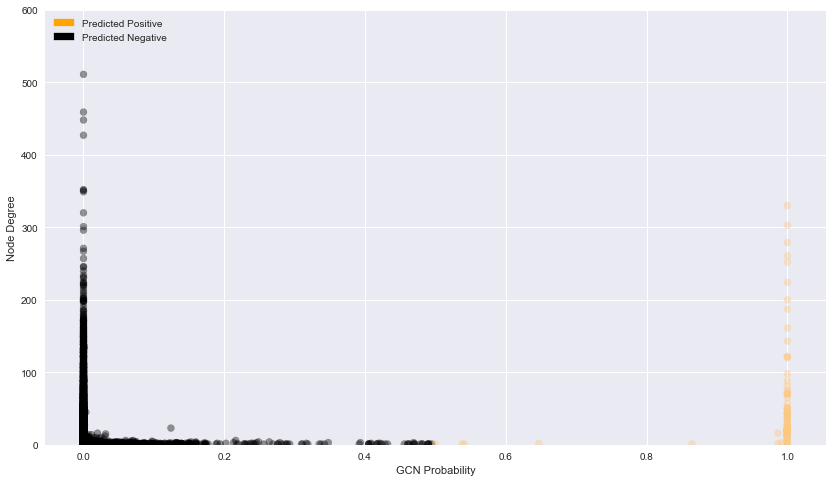

In [165]:
fig = plt.figure(figsize=(14, 8))
plt.scatter(pred_with_feat.Prob_pos, pred_with_feat.neighbors,
            c=pred_with_feat.Prob_pos >= CLASSIFICATION_THRESHOLD,
            cmap=plt.cm.copper, alpha=0.4)
plt.gca().set_ylim([0, 600])
plt.xlabel('GCN Probability')
plt.ylabel('Node Degree')
pred = mpatches.Patch(color='orange', label='Predicted Positive')
non_pred = mpatches.Patch(color='black', label='Predicted Negative')
plt.legend(handles=[pred, non_pred], loc='upper left')
fig.savefig(os.path.join(model_dir, 'degree_correlation.png'))

df_pos = pred_with_feat[pred_with_feat.Prob_pos >= CLASSIFICATION_THRESHOLD]
print ("Correlation of prediction with #neighbors: {}".format(pred_with_feat.Prob_pos.corr(pred_with_feat.neighbors)))
print ("Correlation of prediction with #neighbors for positives: {}".format(df_pos.Prob_pos.corr(df_pos.neighbors)))

In [166]:
labels_with_pred = labels_df.join(predictions, lsuffix='_', how='inner')
predictions_for_pos = labels_with_pred[labels_with_pred.positive == 1]
true_positives = predictions_for_pos[predictions_for_pos.Prob_pos > CLASSIFICATION_THRESHOLD]
no_tp = true_positives.shape[0]
no_positives = predictions_for_pos.shape[0]
pred_pos_test = true_positives[true_positives.testing_set == 1]
pred_pos_train = true_positives[true_positives.training_set == 1]
predictions_for_neg = labels_with_pred[labels_with_pred.negative == 1]
true_negatives = predictions_for_neg[predictions_for_neg.Prob_pos <= CLASSIFICATION_THRESHOLD]
no_tn = true_negatives.shape[0]
no_fn = predictions_for_neg[predictions_for_neg.Prob_pos > CLASSIFICATION_THRESHOLD].shape[0]

print ("Predicted {} out of {} known infection genes".format(no_tp, no_positives)
      )
print ("Out of these {}, {} were not shown during training.".format(no_positives,
                                                                    y_test[:, 0].sum())
      )
print ("Predicted {} out of {} test genes ({}%)".format(pred_pos_test.shape[0],
                                                        y_test[:,0].sum(),
                                                        pred_pos_test.shape[0]/y_test[:,0].sum()*100.)
      )
print ("Predicted {} out of {} train genes ({}%)".format(pred_pos_train.shape[0],
                                                         y_train[:,0].sum(),
                                                         pred_pos_train.shape[0]/y_train[:,0].sum()*100.)
      )
print ("Correctly rejected {} out of {} genes (True Negatives) ({}%)".format(no_tn,
                                                                     predictions_for_neg.shape[0],
                                                                     no_tn/predictions_for_neg.shape[0]*100.))
print ("Falsely predicted {} negatives (FN)".format(no_fn))
predictions_for_neg.sort_values(by='Prob_pos', ascending=False).head(20)

Predicted 74 out of 123 known infection genes
Out of these 123, 49 were not shown during training.
Predicted 0 out of 49 test genes (0.0%)
Predicted 74 out of 74 train genes (100.0%)
Correctly rejected 2257 out of 2258 genes (True Negatives) (99.955713020372%)
Falsely predicted 1 negatives (FN)


,Name_,positive,training_set,testing_set,label,negative,Name,Prob_pos
ENSG00000154611,PSMA8,0,1,0,1,1,PSMA8,0.538
ENSG00000148734,NPFFR1,0,0,1,1,1,NPFFR1,0.500
ENSG00000154646,TMPRSS15,0,1,0,1,1,TMPRSS15,0.490
ENSG00000173250,GPR151,0,1,0,1,1,GPR151,0.482
ENSG00000204640,NMS,0,1,0,1,1,NMS,0.478
ENSG00000139574,NPFF,0,1,0,1,1,NPFF,0.469
ENSG00000133665,DYDC2,0,1,0,1,1,DYDC2,0.456
ENSG00000056291,NPFFR2,0,1,0,1,1,NPFFR2,0.409
ENSG00000227357,HLA-DRB4,0,0,1,1,1,HLA-DRB4,0.408
SEPP1,SEPP1,0,0,1,1,1,SEPP1,0.405


## Train SVM on the Features for Comparison

In [167]:
X_train = features[train_mask.astype(np.bool)]
y_train_svm = y_train[train_mask.astype(np.bool)]

X_test = features[test_mask.astype(np.bool)]
y_test_svm = y_test[test_mask.astype(np.bool)]

clf = svm.SVC(kernel='poly', probability=True, C=0.01, class_weight='balanced')
clf.fit(X_train, y_train_svm.reshape(-1))

pred_svm = clf.predict_proba(X_test)
print ("Number of predicted genes in Test set (SVM): {}".format(pred_svm.argmax(axis=1).sum()))
pred_svm_all = clf.predict_proba(features)
print ("SVM predicts {} genes in total".format(np.argmax(pred_svm_all, axis=1).sum()))

Number of predicted genes in Test set (SVM): 0
SVM predicts 0 genes in total


In [168]:
svm_labels = labels_df
svm_labels['svm_scores'] = pred_svm_all[:, 1]
svm_labels[svm_labels.svm_scores >= CLASSIFICATION_THRESHOLD]

pred_pos_svm = svm_labels[svm_labels.positive == 1]
tp_svm = pred_pos_svm[pred_pos_svm.svm_scores > CLASSIFICATION_THRESHOLD]
no_tp_svm = tp_svm.shape[0]
no_pos_svm = pred_pos_svm.shape[0]
no_pos_test_svm = tp_svm[tp_svm.testing_set == 1].shape[0]
no_pos_train_svm = tp_svm[tp_svm.training_set == 1].shape[0]
pred_neg_svm = svm_labels[svm_labels.negative == 1]
tn_svm = pred_neg_svm[pred_neg_svm.svm_scores <= CLASSIFICATION_THRESHOLD]
no_tn_svm = tn_svm.shape[0]
no_fn_svm = pred_neg_svm[pred_neg_svm.svm_scores > CLASSIFICATION_THRESHOLD].shape[0]

print ("Predicted {} out of {} known infection genes".format(no_tp_svm, no_pos_svm)
      )
print ("Out of these {}, {} were not shown during training.".format(no_pos_svm,
                                                                    y_test[:, 0].sum())
      )
print ("Predicted {} out of {} test genes ({}%)".format(no_pos_test_svm,
                                                        y_test[:,0].sum(),
                                                        no_pos_test_svm/y_test[:,0].sum()*100.)
      )
print ("Predicted {} out of {} train genes ({}%)".format(no_pos_train_svm,
                                                         y_train[:,0].sum(),
                                                         no_pos_train_svm/y_train[:,0].sum()*100.)
      )
print ("Correctly rejected {} out of {} genes (True Negatives) ({}%)".format(no_tn_svm,
                                                                     pred_neg_svm.shape[0],
                                                                     no_tn_svm/pred_neg_svm.shape[0]*100.))
print ("Falsely predicted {} negatives (FN)".format(no_fn_svm))

Predicted 0 out of 123 known infection genes
Out of these 123, 49 were not shown during training.
Predicted 0 out of 49 test genes (0.0%)
Predicted 0 out of 74 train genes (0.0%)
Correctly rejected 2257 out of 2257 genes (True Negatives) (100.0%)
Falsely predicted 0 negatives (FN)


In [169]:
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train, y_train_svm.reshape(-1))
pred_lr = logreg.predict_proba(X_test)
print ("Number of predicted genes in Test set (LogReg): {}".format(pred_lr.argmax(axis=1).sum()))
pred_lr_all = clf.predict_proba(features)
print ("LogReg predicts {} genes in total".format(np.argmax(pred_lr_all, axis=1).sum()))

Number of predicted genes in Test set (LogReg): 351
LogReg predicts 0 genes in total


(12129, 7) (12135, 16)
Correlation of prediction with #neighbors: 0.08729129140248272
Correlation of prediction with #neighbors for positives: 0.18569434890819939


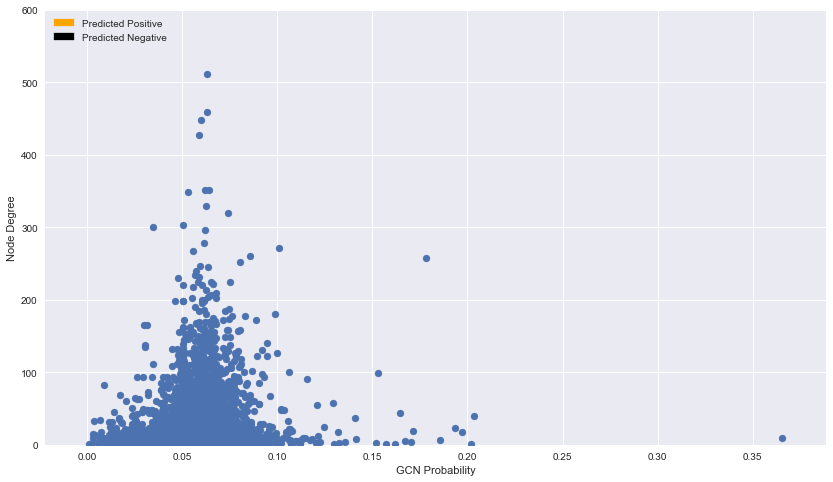

In [170]:
print (svm_labels.shape, pred_with_feat.shape)
fig = plt.figure(figsize=(14, 8))
plt.scatter(svm_labels.svm_scores, network.sum(axis=1),
            cmap=plt.cm.copper, alpha=1)
plt.gca().set_ylim([0, 600])
plt.xlabel('GCN Probability')
plt.ylabel('Node Degree')
pred = mpatches.Patch(color='orange', label='Predicted Positive')
non_pred = mpatches.Patch(color='black', label='Predicted Negative')
plt.legend(handles=[pred, non_pred], loc='upper left')
fig.savefig(os.path.join(model_dir, 'degree_correlation_svm.png'))

df_pos = pred_with_feat[pred_with_feat.Prob_pos >= CLASSIFICATION_THRESHOLD]
print ("Correlation of prediction with #neighbors: {}".format(pred_with_feat.Prob_pos.corr(pred_with_feat.neighbors)))
print ("Correlation of prediction with #neighbors for positives: {}".format(df_pos.Prob_pos.corr(df_pos.neighbors)))

(12129, 2) (952,)
ACCURACY: 0.9474789915966386


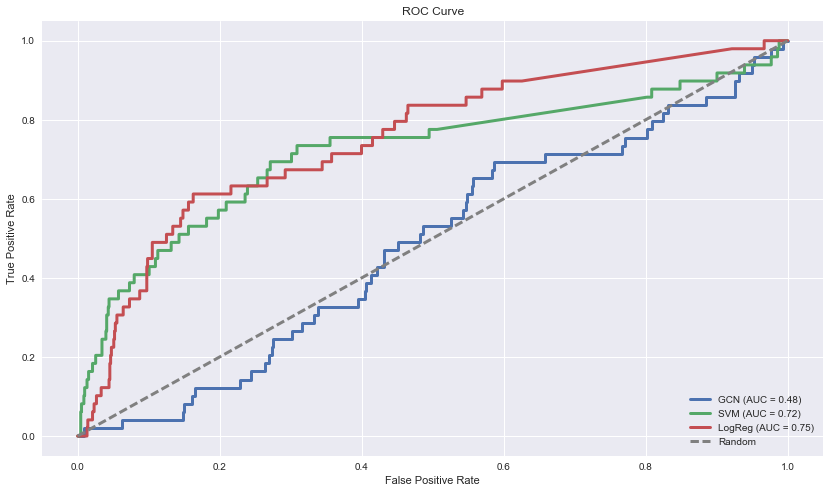

In [171]:
#y_score = predictions.Prob_pos
#y_true = np.logical_or(y_train, y_test)
y_true = y_test[test_mask == 1, 0]
y_score = predictions[test_mask == 1].Prob_pos
fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_score)
roc_auc = roc_auc_score(y_true=y_true, y_score=y_score)

# compute roc for SVM
print (pred_svm_all.shape, y_true.shape)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_true=y_true, y_score=pred_svm[:, 1])
roc_auc_svm = roc_auc_score(y_true=y_true, y_score=pred_svm[:, 1])

# compute ROC for Logistic Regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_true=y_true, y_score=pred_lr[:, 1])
roc_auc_lr = roc_auc_score(y_true=y_true, y_score=pred_lr[:, 1])

# plot ROC curve
fig = plt.figure(figsize=(14, 8))
plt.plot(fpr, tpr, lw=3, label='GCN (AUC = {0:.2f})'.format(roc_auc))
plt.plot(fpr_svm, tpr_svm, lw=3, label='SVM (AUC = {0:.2f})'.format(roc_auc_svm))
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogReg (AUC = {0:.2f})'.format(roc_auc_lr))
plt.plot([0, 1], [0, 1], color='gray', lw=3, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
fig.savefig(os.path.join(model_dir, 'roc_curve.png'))
acc = accuracy_score(y_true=y_true,
                     y_pred=y_score >= CLASSIFICATION_THRESHOLD)
print ("ACCURACY: {}".format(acc))

In [172]:
pred_svm[y_true == 1, 1]

array([0.0635525 , 0.05044054, 0.08185532, 0.08024844, 0.07016082,
       0.05843328, 0.05981548, 0.06176517, 0.08292423, 0.03429461,
       0.0794336 , 0.07002939, 0.04203734, 0.03025019, 0.05044054,
       0.06499701, 0.0290102 , 0.06916898, 0.06277959, 0.04632756,
       0.05707799, 0.05749297, 0.0946199 , 0.05044054, 0.05095304,
       0.05571738, 0.06039592, 0.06001865, 0.06135145, 0.09053523,
       0.06902449, 0.06855308, 0.05044054, 0.05940289, 0.0610669 ,
       0.05858453, 0.07314225, 0.04863999, 0.09021094, 0.07526355,
       0.08579028, 0.06894021, 0.05020979, 0.06873734, 0.06250089,
       0.05888194, 0.06447194, 0.06675457, 0.05951765])

In [173]:
distances = np.sqrt(np.sum((np.array([0, 1]) - np.array([fpr, tpr]).T)**2, axis=1))
idx = np.argmin(distances)
best_threshold = tpr[idx]
print ("Optimal classification threshold: {}".format(best_threshold))

BEST_THRESHOLD = best_threshold

Optimal classification threshold: 0.6530612244897959


In [174]:
confusion_matrix(y_true=y_true, y_pred=y_score >= BEST_THRESHOLD)

array([[903,   0],
       [ 49,   0]])

In [175]:
confusion_matrix(y_true=y_true, y_pred=pred_svm[:, 1] >= CLASSIFICATION_THRESHOLD)

array([[903,   0],
       [ 49,   0]])

0.051470588235294115 49 903.0


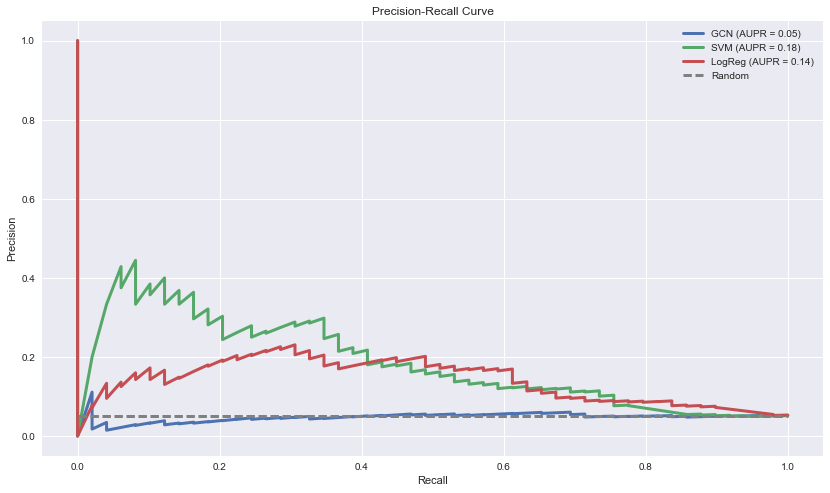

In [176]:
# calculate precision and recall for GCN
pr, rec, thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_score)
aupr = average_precision_score(y_true=y_true, y_score=y_score)

# calculate precision and recall for SVM
pr_svm, rec_svm, thresholds_svm = precision_recall_curve(y_true=y_true, probas_pred=pred_svm[:, 1])
aupr_svm = average_precision_score(y_true=y_true, y_score=pred_svm[:, 1])

# calculate precision and recall for Logistic Regression
pr_lr, rec_lr, thresholds_lr = precision_recall_curve(y_true=y_true, probas_pred=pred_lr[:, 1])
aupr_lr = average_precision_score(y_true=y_true, y_score=pred_lr[:, 1])

fig = plt.figure(figsize=(14, 8))
plt.plot(rec, pr, lw=3, label='GCN (AUPR = {0:.2f})'.format(aupr))
plt.plot(rec_svm, pr_svm, lw=3, label='SVM (AUPR = {0:.2f})'.format(aupr_svm))
plt.plot(rec_lr, pr_lr, lw=3, label='LogReg (AUPR = {0:.2f})'.format(aupr_lr))
random_y = y_true.sum() / (y_true.sum() + y_true.shape[0] - y_true.sum())
print (random_y, y_true.sum(), y_true.shape[0]-y_true.sum())
plt.plot([0, 1], [random_y, random_y], color='gray', lw=3, linestyle='--', label='Random')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
fig.savefig(os.path.join(model_dir, 'prec_recall.png'))

#print ("Precision: {}\tRecall: {}".format(precision, recall))

## Investigate New Model GCN Parameters

In [126]:
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
checkpoint_path = os.path.join(model_dir, "model.ckpt")
#print_tensors_in_checkpoint_file(file_name=checkpoint_path, tensor_name='', all_tensors=True)


In [128]:
tf.reset_default_graph()
adj = csr_matrix(network)
F = lil_matrix(features)
F = preprocess_features(F)

poly_support = args['support']
if poly_support > 1:
    support = chebyshev_polynomials(adj, poly_support)
    num_supports = 1 + poly_support
else:
    support = [preprocess_adj(adj)]
    num_supports = 1
print (len(support))
print ([s[2] for s in support])
print (y_train.shape)
print (features.shape)

placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32,
                                      shape=tf.constant(features.shape, dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

def predict(features, support, labels, mask, placeholders):
    feed_dict_pred = construct_feed_dict(features, support, labels, mask, placeholders)
    pred = sess.run(model.predict(), feed_dict=feed_dict_pred)
    return pred

ckpt = tf.train.get_checkpoint_state(checkpoint_dir=model_dir)
ckpt.model_checkpoint_path

if ckpt and ckpt.model_checkpoint_path:
    with tf.Session() as sess:
        model = MYGCN(placeholders,
                      input_dim=features.shape[1],
                      learning_rate=args['lr'],
                      hidden_dims=args['hidden_dims'],
                      pos_loss_multiplier=args['loss_mul'],
                      weight_decay=args['decay'],
                      logging=True)
        model.load(checkpoint_path, sess)
        print ("loaded")
        weight_matrices = []
        for var in model.vars: # chebychev coefficients
            weight_matrices.append(model.vars[var].eval(session=sess))

        # predict for test set and catch activations in H_1, H_2
        feed_dict = construct_feed_dict(features=F,
                                        support=support,
                                        labels=y_train,
                                        labels_mask=train_mask,
                                        placeholders=placeholders
                                       )
        #l = sess.run(model.loss, feed_dict=feed_dict)
        activations = []
        for layer_act in model.activations:
            activation = sess.run(layer_act, feed_dict=feed_dict)
            activations.append(activation)

len(activations), len(weight_matrices)

/home/sasse/.local/lib/python3.6/site-packages/gcn-1.0-py3.6.egg/gcn/utils.py:97: RuntimeWarning: divide by zero encountered in power


Calculating Chebyshev polynomials up to order 2...
3
[(12129, 12129), (12129, 12129), (12129, 12129)]
(12129, 1)
(12129, 12)
INFO:tensorflow:Restoring parameters from ../data/GCN/training/2018_02_21_16_47_47/model.ckpt
loaded


(4, 9)

## Investigate with LRP

In [129]:
# convert support to coo matrices
support_coo = [coo_matrix((s[1], (s[0][:,1], s[0][:,0])), shape=s[2]) for s in support]

# test if that worked
first_okay = np.array_equal(support_coo[0].todense(), np.eye(network.shape[0]))
print ("First support matrix okay? {}".format(first_okay))
adj = network
adj_normalized = normalize_adj(adj)
laplacian = sp.eye(adj.shape[0]) - adj_normalized
largest_eigval, _ = eigsh(laplacian, 1, which='LM')
scaled_laplacian = (2. / largest_eigval[0]) * laplacian - sp.eye(adj.shape[0])
second_okay = np.allclose(support_coo[1].todense(), scaled_laplacian.todense())
print ("Second support matrix okay? {}".format(second_okay))
cheby_2 = 2*scaled_laplacian.dot(scaled_laplacian) - np.eye(adj.shape[0])
third_okay = np.allclose(support_coo[2].todense(), cheby_2)
print ("Third support matrix okay? {}".format(third_okay))



First support matrix okay? True
Second support matrix okay? True
Third support matrix okay? True


In [130]:
R_out = 1
R_j = R_out
for layer in range(len(activations)-1, 1, -1): # going from last to first layer (without first)
    #print ("Layer: {}".format(layer))
    if args['support'] > 1:
        base_idx = layer*(args['support']+1) - args['support'] - 1
        R_i = 0 # sum over it to obtain final result
        act_i = activations[layer-1]
        for s in range(args['support']+1): # sum over the support
            idx = base_idx + s
            a_s = act_i.shape
            w_s = weight_matrices[idx].shape
            print ("w_{}\tShape: {}\tActivation Shape: {}".format(idx, w_s, a_s))
            V = np.maximum(0, weight_matrices[idx])
            Z = np.dot(np.dot(support_coo[s].todense(), act_i), V) + 1e-9
            S = R_j / Z
            #print (Z.shape, S.shape)
            C = np.dot(S, V.T)
            #print (C.shape, act_i.shape)
            R = np.multiply(act_i, C)
            R_i += R
        R_j = R_i
        print (R_j.var())

act_0_sp = activations[0]
act_0_coo = coo_matrix((act_0_sp.values,
                        (act_0_sp.indices[:, 0], act_0_sp.indices[:, 1])),
                        shape=act_0_sp.dense_shape)
act_0 = act_0_coo.todense()
for s in range(args['support']):
    W = weight_matrices[s]
    V = np.maximum(0, W)
    U = np.minimum(0, W)
    X = act_0
    L = act_0*0 + act_0.min()
    H = act_0*0 + act_0.max()
    Z = np.dot(act_0, W) - np.dot(L, V) - np.dot(H,U) + 1e-9
    S = R_j / Z
    R_0 = np.multiply(act_0, np.dot(S, W.T)) - np.multiply(L, np.dot(S, V.T)) - np.multiply(H, np.dot(S, U.T))
print (R_0.shape)

w_6	Shape: (80, 1)	Activation Shape: (12129, 80)
w_7	Shape: (80, 1)	Activation Shape: (12129, 80)
w_8	Shape: (80, 1)	Activation Shape: (12129, 80)
783.1065001996723
w_3	Shape: (40, 80)	Activation Shape: (12129, 40)
w_4	Shape: (40, 80)	Activation Shape: (12129, 40)
w_5	Shape: (40, 80)	Activation Shape: (12129, 40)
432647.3377220564
(12129, 12)


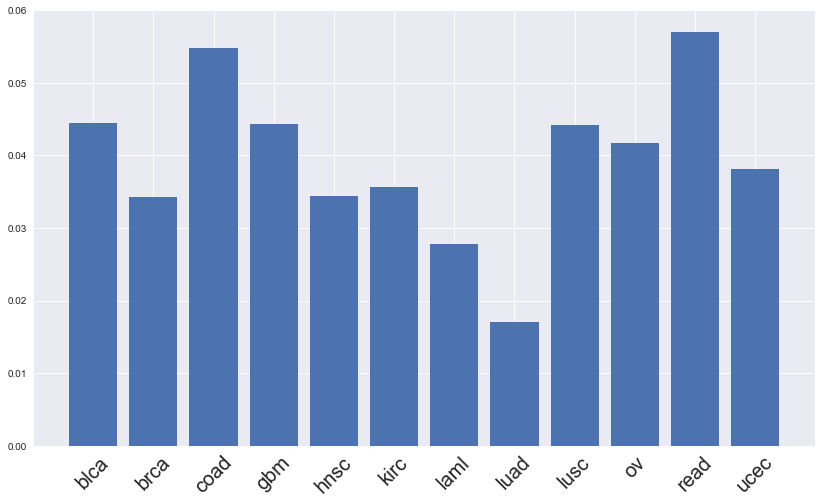

In [133]:
# query the relevancec propagation
labels_df['idx_num'] = np.arange(labels_df.shape[0])
idx_interest = labels_df[labels_df.Name == 'TP53'].idx_num
fig = plt.figure(figsize=(14, 8))
x = range(features.shape[1])
plt.bar(x, np.array(R_0[idx_interest]).reshape(-1))
if features.shape[1] == 12:
    labels = ['blca', 'brca', 'coad', 'gbm', 'hnsc', 'kirc', 'laml', 'luad', 'lusc', 'ov', 'read', 'ucec']
    x = plt.gca().set_xticks(np.arange(len(labels)))
    x = plt.gca().set_xticklabels(labels, rotation=45, fontsize=20)

In [147]:
pos_classified = labels_with_pred.Prob_pos >= CLASSIFICATION_THRESHOLD

# set the colors according to classes
labels_with_pred['color'] = 'gray'
labels_with_pred.loc[pos_classified, 'color'] = 'red'
labels_with_pred.loc[~labels_with_pred.label & pos_classified, 'color'] = 'green'
labels_with_pred.groupby('color').count()

,Name_,positive,training_set,testing_set,label,negative,Name,Prob_pos
color,,,,,,,,
gray,11357,11357,11357,11357,11357,11357,11357,11357
green,638,638,638,638,638,638,638,638
red,140,140,140,140,140,140,140,140


Plotted TSNE for activation in layer 1 successfully
Plotted TSNE for activation in layer 2 successfully
Plotted TSNE for activation in layer 3 successfully
Plotted TSNE for activation in layer 4 successfully


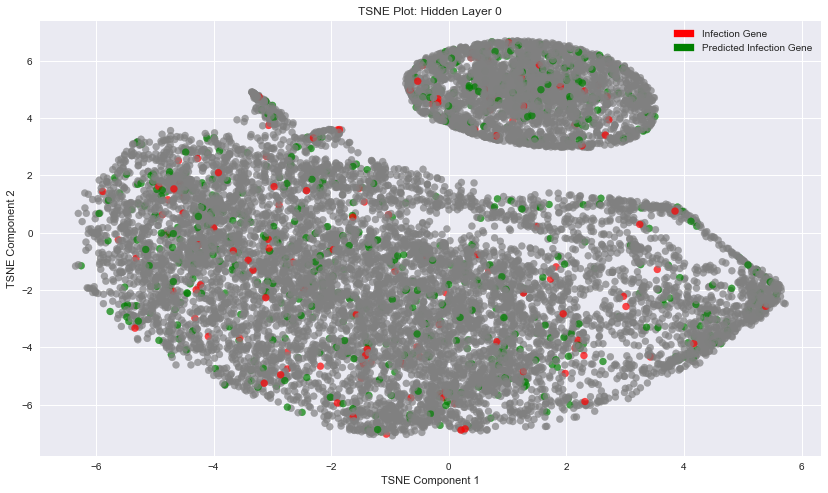

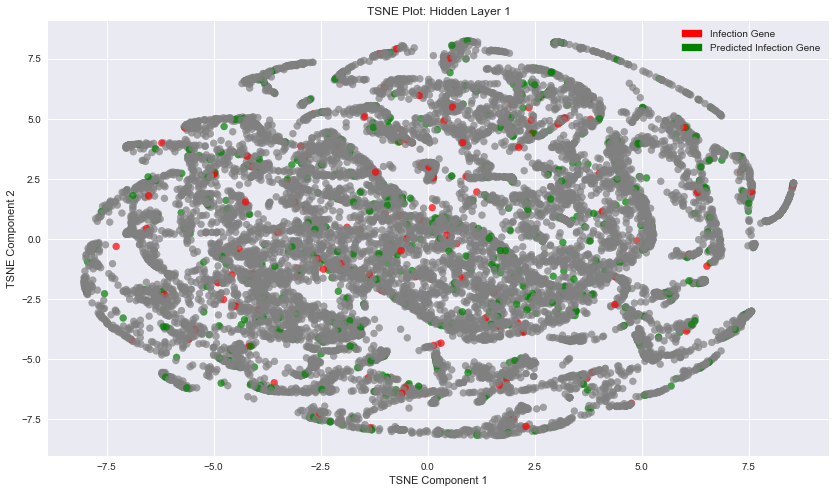

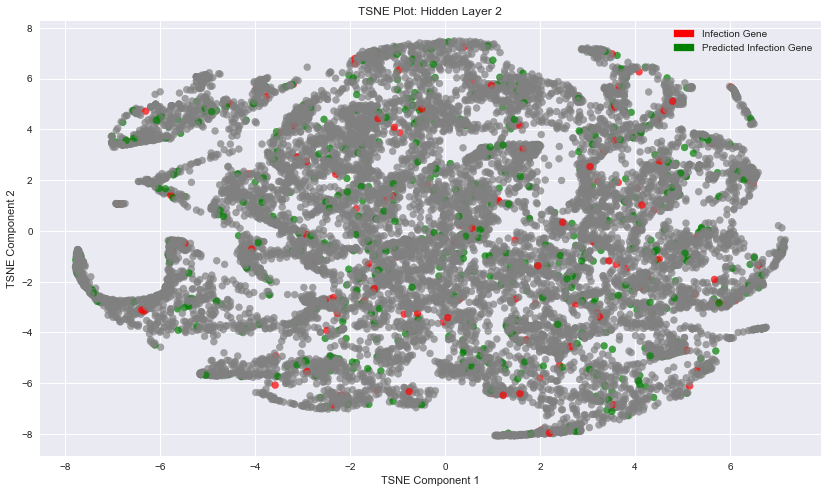

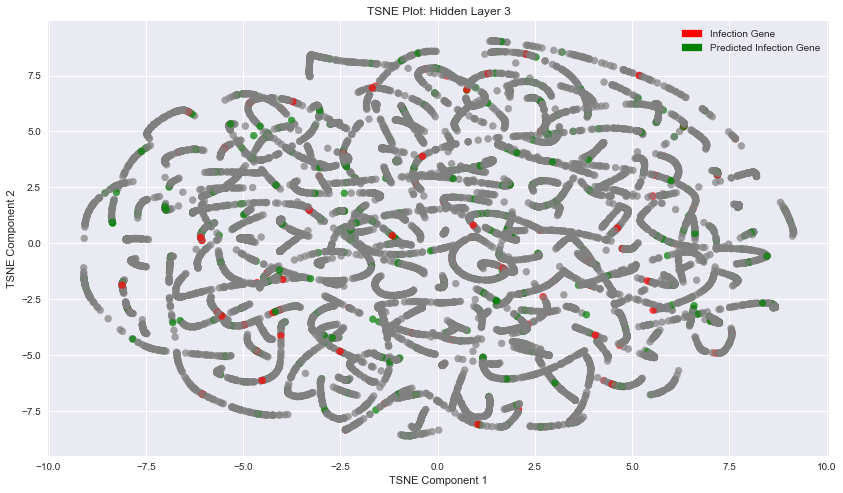

In [148]:
layer_num = 0
embeddings = []
for act in activations:
    if layer_num == 0:
        input_data = coo_matrix((act.values,
                                (act.indices[:, 0], act.indices[:, 1])),
                                shape=act.dense_shape)
        embedding = TSNE(n_components=2).fit_transform(input_data.todense())
    else:
        embedding = TSNE(n_components=2).fit_transform(act)
    embeddings.append(embedding)
    fig = plt.figure(figsize=(14, 8))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=labels_with_pred.color, alpha=0.7)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.title('TSNE Plot: Hidden Layer {}'.format(layer_num))

    # legend
    inf_genes = mpatches.Patch(color='red', label='Infection Gene')
    pred_genes = mpatches.Patch(color='green', label='Predicted Infection Gene')
    not_involved = mpatches.Patch(color='gray', label='Not Involved in Infection')
    plt.legend(handles=[inf_genes, pred_genes])

    # save
    fig.savefig(model_dir + '/tsne_{}.png'.format(layer_num), dpi=300)
    layer_num += 1
    print ("Plotted TSNE for activation in layer {} successfully".format(layer_num))

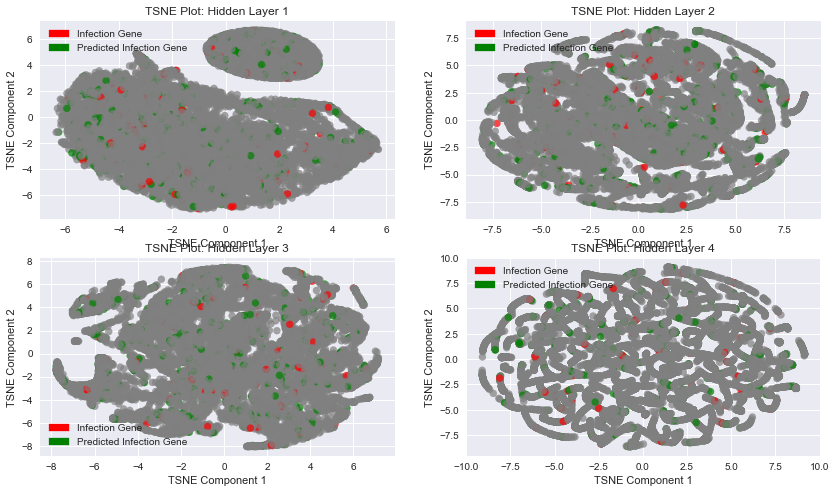

In [149]:
# one plot for all the TSNEs
fig = plt.figure(figsize=(14, 8))
x, y = bestSplit(len(embeddings))
count = 1
for embedding in embeddings:
    plt.subplot(x, y, count)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=labels_with_pred.color, alpha=0.7)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.title('TSNE Plot: Hidden Layer {}'.format(count))

    # legend
    inf_genes = mpatches.Patch(color='red', label='Infection Gene')
    pred_genes = mpatches.Patch(color='green', label='Predicted Infection Gene')
    not_involved = mpatches.Patch(color='gray', label='Not Involved in Infection')
    plt.legend(handles=[inf_genes, pred_genes])
    count += 1
fig.savefig('TSNE_all_layers.png', dpi=200)

## Do the predictions have special properties?
I want to check the shortest path between predicted disease genes and true disease genes as well.
Further, I want to see them in a network.

In [11]:
# build networkx graph with correct node names
G = nx.from_numpy_matrix(network)
#mapping = {i:node_names[i, 0] for i in range(node_names.shape[0])}
#nx.relabel_nodes(G, mapping, copy=False)

### Betweenness Centrality

In [10]:
G = nx.from_numpy_array(network)
betweenness = nx.betweenness_centrality(G)

Correlation between betweenness and GCN probability: 0.2145957591597404


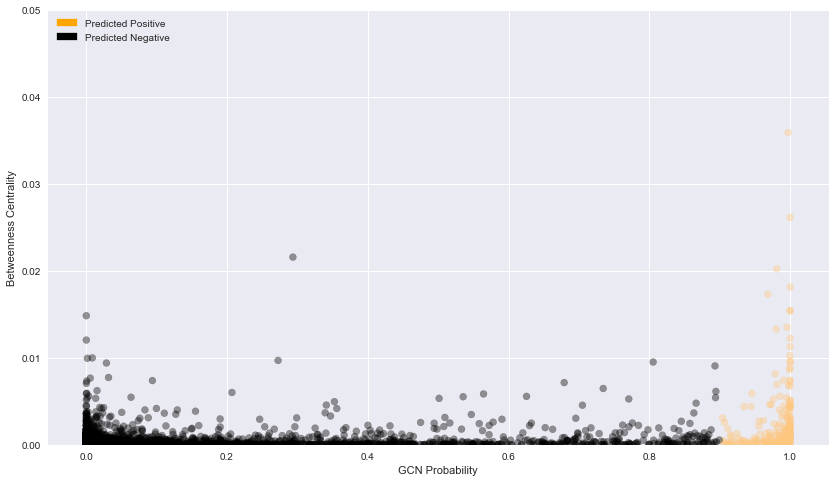

In [57]:
betweenness_list = [betweenness[i] for i in range(network.shape[0])]
betweenness_df = pd.DataFrame(node_names, index=node_names[:, 0], columns=['ID', 'Name']).drop(['ID'], axis=1)
betweenness_df['betweenness'] = betweenness_list # works, because node_names has same order as network
betweenness_df['degree'] = network.sum(axis=0)
betweenness_df = betweenness_df.reindex(predictions.index)

fig = plt.figure(figsize=(14, 8))
plt.scatter(predictions.Prob_pos, betweenness_df.betweenness,
            c=predictions.Prob_pos >= CLASSIFICATION_THRESHOLD,
            cmap=plt.cm.copper, alpha=0.4)
plt.gca().set_ylim([0, 0.05])
plt.xlabel('GCN Probability')
plt.ylabel('Betweenness Centrality')
pred = mpatches.Patch(color='orange', label='Predicted Positive')
non_pred = mpatches.Patch(color='black', label='Predicted Negative')
plt.legend(handles=[pred, non_pred], loc='upper left')
fig.savefig(os.path.join(model_dir, 'betweenness_correlation.png'))

print ("Correlation between betweenness and GCN probability: {}".format(betweenness_df.betweenness.corr(predictions.Prob_pos)))

### Shortest Paths

In [331]:
# calculate shortest paths between all nodes and make it a dataframe matrix
all_shortest_paths = nx.shortest_path_length(G)
sp_df = pd.DataFrame(dict(all_shortest_paths))

In [358]:
sp_df['name'] = node_names[:, 0]

(2386, 12130)

In [359]:
# build views for label to label shortest paths and non-label to non-label
label_cond = sp_df.name.isin(pos_predicted.index)
sp_df.drop('name', axis=1, inplace=True)
label_to_label = sp_df.loc[label_cond, label_cond]
nonlabel_to_nonlabel = sp_df.loc[~label_cond, ~label_cond]
label_to_nonlabel = sp_df.loc[~label_cond, label_cond]

(5692996,) (94926049,) (23246798,)


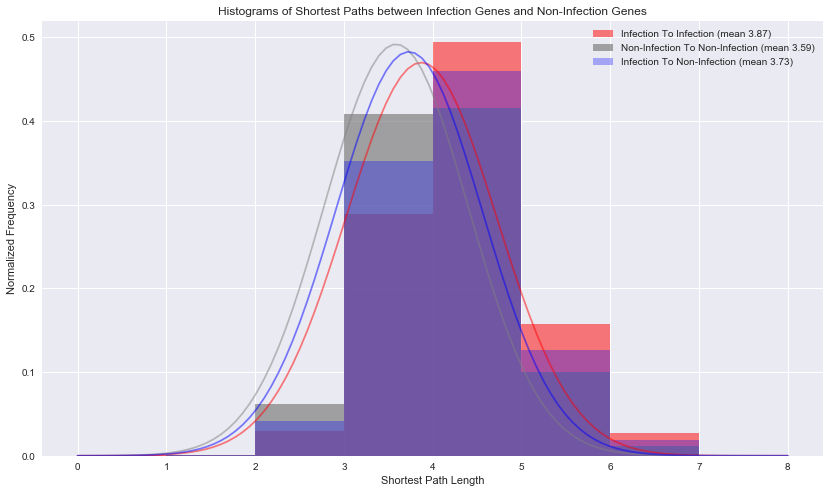

In [361]:
# plot the distributions
fig = plt.figure(figsize=(14, 8))
bins = np.arange(0, 8, 1)

ltl = pd.Series(label_to_label.values.flatten()).dropna()
ntn = pd.Series(nonlabel_to_nonlabel.values.flatten()).dropna()
ltn = pd.Series(label_to_nonlabel.values.flatten()).dropna()
print (ltl.shape, ntn.shape, ltn.shape)
plt.hist(ltl, bins=bins, alpha=.5, normed=True, color='red',
         label='Infection To Infection (mean {0:.2f})'.format(ltl.mean()))
plt.hist(ntn, bins=bins, alpha=.7, normed=True, color='gray',
         label='Non-Infection To Non-Infection (mean {0:.2f})'.format(ntn.mean()))
plt.hist(ltn, bins=bins, alpha=.3, normed=True, color='blue',
         label='Infection To Non-Infection (mean {0:.2f})'.format(ltn.mean()))
points = np.linspace(0, 8, 100)
plt.plot(points, mlab.normpdf(points, ltl.mean(), ltl.std()), color='red', alpha=0.5)
plt.plot(points, mlab.normpdf(points, ntn.mean(), ntn.std()), color='gray', alpha=0.5)
plt.plot(points, mlab.normpdf(points, ltn.mean(), ltn.std()), color='blue', alpha=0.5)
plt.legend()
plt.title('Histograms of Shortest Paths between Infection Genes and Non-Infection Genes')
plt.xlabel('Shortest Path Length')
plt.ylabel('Normalized Frequency')
fig.savefig(os.path.join(model_dir, 'path_length_distribution.png'))

### Node Degree

In [12]:
degree_df = pd.Series(dict(all_node_degrees))
degree_df = pd.DataFrame(degree_df, index=node_names[:, 0])
degree_df.isnull().sum()

NameError: name 'all_node_degrees' is not defined

In [364]:
# calculate shortest paths between all nodes and make it a dataframe matrix
all_node_degrees = G.degree()
degree_df = pd.Series(dict(all_node_degrees))

degree_df['name'] = node_names[:, 0]

# build views for label and non-label degrees
label_cond = degree_df.name.isin(pos_predicted.index)
labels = degree_df[label_cond]
nonlabels = degree_df[~label_cond]
print (labels.shape, nonlabels.shape)

# plot histograms
fig = plt.figure(figsize=(14, 8))
bins = np.arange(0, 50, 1)
plt.hist(labels, bins=bins, alpha=.5, normed=True, color='red',
         label='Infection Genes (Median {})'.format(labels.median()))
plt.hist(nonlabels, bins=bins, alpha=.7, normed=True, color='gray',
         label='Other Genes (Median {})'.format(nonlabels.median()))
plt.legend()
plt.title('Histograms of Node Degree for Infection and Other Genes')
plt.xlabel('Node Degree')
plt.ylabel('Normalized Frequency')
fig.savefig(os.path.join(model_dir, 'node_degrees.png'))

AttributeError: 'NoneType' object has no attribute 'isin'

### Probability that Neighbor of Infection Gene is also Infection Gene

In [ ]:
# half because of symmetric matrix
num_of_neighbor_labels = label_to_label[label_to_label == 1].count().sum() / 2
prob_neighbor_label = (num_of_neighbor_labels / label_to_label.shape[0]) * 100
print ("Chance of label to have labeled neighbor: {0:.2f} %".format(prob_neighbor_label))

In [ ]:
num_label_nbs = []
num_nbs = []
for label in predictions.index:
    nbs = list(nx.all_neighbors(G, label))
    label_nbs = predictions_for_knowns.index.isin(nbs).sum()
    num_label_nbs.append(label_nbs)
    num_nbs.append(len(nbs))
num_label_nbs = np.array(num_label_nbs)
num_total_nbs = np.array(num_nbs)
print ("Number of labeled neighbors: {}".format(num_label_nbs.sum()))
print ("Number of neighbors total: {}".format(num_total_nbs.sum()))
freq = num_label_nbs.sum()/num_total_nbs.sum()
print ("Chance that neighbor is labeled: {0:.4f}".format(freq))

(array([3533.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        8596.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

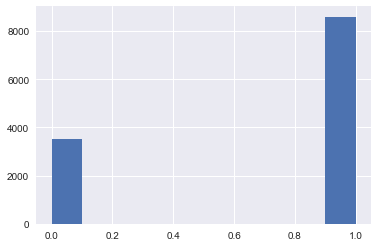

In [296]:
plt.hist(np_input)

In [297]:
rowsum = features.sum(1)
r_inv = np.power(rowsum, -1).flatten()
r_inv[np.isinf(r_inv)] = 0.
r_mat_inv = np.diag(r_inv)
f2 = r_mat_inv.dot(features)

/pkg/python-3.6.0-0/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in power
  from ipykernel import kernelapp as app


## Correlation with other methods
I will now try to see how similar my performance is to NetRank and PageRank.

In [ ]:
netrank_scores = pd.DataFrame.from_csv('../data/pagerank/netrank_scores.txt', header=0, sep='\t')
netrank_scores.rename(columns={'Rank': 'NetRank_Rank'})
predictions.sort_values('Prob_pos', ascending=False, inplace=True)
predictions['GCN_Rank'] = np.arange(1, predictions.shape[0]+1)
print ("Correlation Rank & Prob: {}".format(predictions.Prob_pos.corr(predictions.GCN_Rank)))

In [ ]:
netrank_with_predictions = predictions.join(netrank_scores, how='inner')
fig = plt.figure(figsize=(14, 14))
plt.scatter(netrank_with_predictions.GCN_Rank, netrank_with_predictions.Rank, color='gray')
lin = np.arange(1, netrank_with_predictions.shape[0]+1)
plt.plot(lin, lin, '--', color='black')

print ("Correlation between NetRank and GCN: {}".format(netrank_with_predictions.Rank.corr(netrank_with_predictions.GCN_Rank)))

In [ ]:
netrank_scores.head()